# 🧠 Model Training

## Importaciones

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image 
from PIL import ImageOps

## Obtención de datos

**Fuente:** [dataset_vectorized.csv](https://raw.githubusercontent.com/Latency-Zero-tfm/HardVisionAI/refs/heads/main/data/processed/dataset_vectorized.csv)

Utilizaremos nuestro dataset resultante del web scraping de distintas páginas, ya procesado y listo para usar en nuestro modelo.


In [8]:
df = pd.read_csv('../data/processed/components_03.csv')

## Procesamiento de imágenes

### Procesamiento y vectorización de imágenes

En este paso, redimensionamos las imágenes a una proporción estándar y las convertimos en vectores numéricos, lo que permite su posterior análisis y uso en nuestro futuro modelo.

In [9]:
target_size = (530, 530)

data = []

for idx, row in df.iterrows():
    path = row["local_image_path"]
    label = row["label"]
    
    img = Image.open(path).convert("RGB")
    img_resized = ImageOps.fit(img, target_size, Image.Resampling.LANCZOS)
    img_vector = np.array(img_resized).flatten()
    
    data.append([label, img_vector])

df_vector = pd.DataFrame(data, columns=["label", "image"])


In [10]:
df_vector.info()

<class 'pandas.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9971 non-null   int64 
 1   image   9971 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.9+ KB


In [11]:
df_vector

,label,image
0,0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1,0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
2,0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
3,0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
4,0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
...,...,...
9966,3,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
9967,3,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
9968,3,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
9969,3,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."


## Descripción de los datos

El dataset cuenta con  y **2 columnas**, de las cuales `label` es de tipo `int64` e `image` es de tipo `object`, ya que contiene la imagen vectorizada.

| Columna | Tipo   | Descripción                                        |
| ------- | ------ | -------------------------------------------------- |
| image   | object | Imagen vectorizada del componente de computadora   |
| label   | int64  | Etiqueta numérica que indica el tipo de componente |

El **target** que se busca predecir es el **label**, es decir, el tipo de componente.

| Número | Componente     |
| ------ | -------------- |
| 0      | motherboard    |
| 1      | gpu            |
| 2      | cpu            |
| 3      | hard_drive     |
| 4      | ram            |
| 5      | pc_case        |
| 6      | power_supply   |
| 7      | liquid_cooling |
| 8      | case_fan       |
| 9      | cpu_fan        |
| 10     | sound_card     |



<!-- {0: 'motherboard', 1: 'gpu', 2: 'cpu', 3: 'hard_drive', 4: 'ram', 5: 'pc_case', 6: 'power_supply', 7: 'liquid_cooling', 8: 'case_fan', 9: 'cpu_fan', 10: 'sound_card'} -->


## Exploración y visualización de los datos

Se realizará un estudio de los datos mostrando gráficas, observando si hay valores nulos, etc.

### Tipos de componentes:

| Número | Componente     |
| ------ | -------------- |
| 0      | motherboard    |
| 1      | gpu            |
| 2      | cpu            |
| 3      | hard_drive     |
| 4      | ram            |
| 5      | pc_case        |
| 6      | power_supply   |
| 7      | liquid_cooling |
| 8      | case_fan       |
| 9      | cpu_fan        |
| 10     | sound_card     |


In [12]:
label_map = {
    0: 'motherboard',
    1: 'gpu',
    2: 'cpu',
    3: 'hard_drive',
    4: 'ram',
    5: 'pc_case',
    6: 'power_supply',
    7: 'liquid_cooling',
    8: 'case_fan',
    9: 'cpu_fan',
    10: 'sound_card'
}

### Distribución de imágenes por tipo de componente

En nuestro conjunto de casi 10,000 imágenes, la distribución por tipo de componente muestra una variedad relativamente equilibrada entre varias categorías, aunque con algunas diferencias destacables. Por ejemplo, los componentes como el **disco duro** y la **caja del PC** representan una proporción considerablemente mayor (19.0% y 18.3%, respectivamente), mientras que otros como la **tarjeta de sonido** apenas alcanzan el 0.5%.  

Estas variaciones reflejan una presencia más frecuente de ciertos componentes en el conjunto de datos, lo que está relacionado con su disponibilidad visual o relevancia técnica.



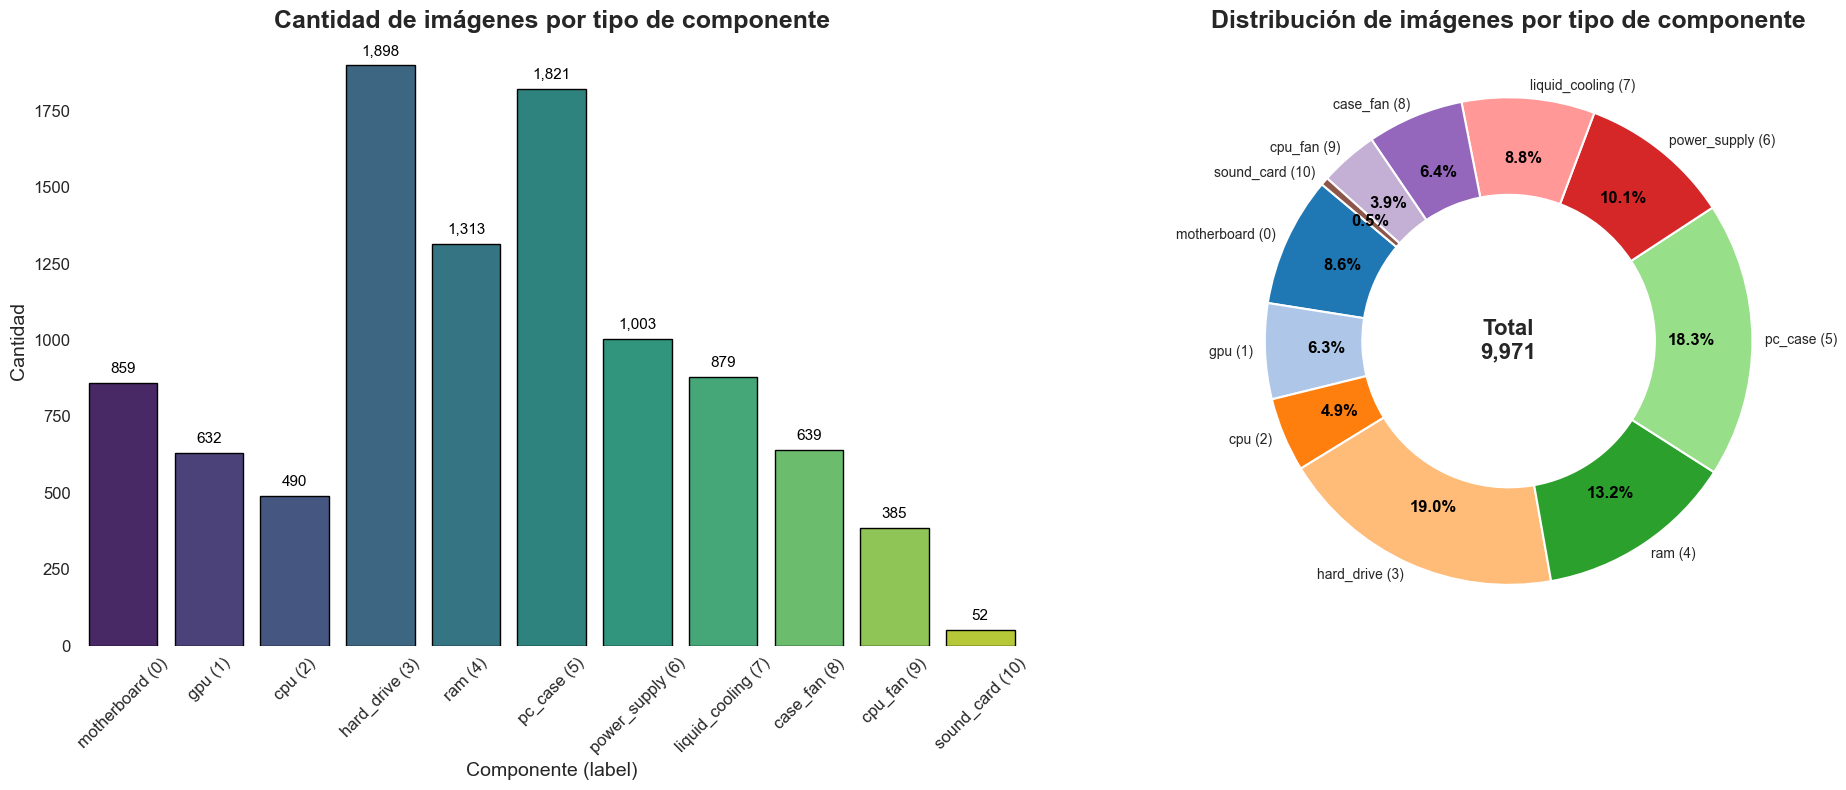

In [13]:
label_counts = df_vector["label"].value_counts().sort_index().reset_index()
label_counts.columns = ["label", "count"]
label_counts["label_display"] = label_counts["label"].map(label_map) + " (" + label_counts["label"].astype(str) + ")"

labels = label_counts["label_display"]
sizes = label_counts["count"]
total_images = sizes.sum()
colors = plt.cm.tab20.colors[:len(labels)]

sns.set_style("white")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

barplot = sns.barplot(
    x="label_display",
    y="count",
    data=label_counts,
    hue="label_display",
    palette="viridis",
    edgecolor="black",
    legend=False,
    ax=axes[0]
)

for patch in barplot.patches:
    height = patch.get_height()
    barplot.annotate(
        f"{int(height):,}",
        (patch.get_x() + patch.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=11,
        color="black",
        xytext=(0, 5),
        textcoords="offset points"
    )

axes[0].set_title("Cantidad de imágenes por tipo de componente", fontsize=18, weight="bold")
axes[0].set_xlabel("Componente (label)", fontsize=14)
axes[0].set_ylabel("Cantidad", fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
sns.despine(ax=axes[0], left=True, bottom=True)

wedges, texts, autotexts = axes[1].pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    wedgeprops={"width":0.4, "edgecolor":"white", "linewidth":1.5},
    pctdistance=0.75,
    labeldistance=1.05
)

for autotext in autotexts:
    autotext.set_color("black")
    autotext.set_fontsize(12)
    autotext.set_weight("bold")

axes[1].text(0, 0, f"Total\n{total_images:,}", ha="center", va="center", fontsize=16, weight="bold")
axes[1].set_aspect("equal")
axes[1].set_title("Distribución de imágenes por tipo de componente", fontsize=18, weight="bold")

plt.tight_layout()
plt.show()


### Visualización de imágenes

Vamos a visualizar algunas imágenes para ver cómo están guardadas y cómo se verían.


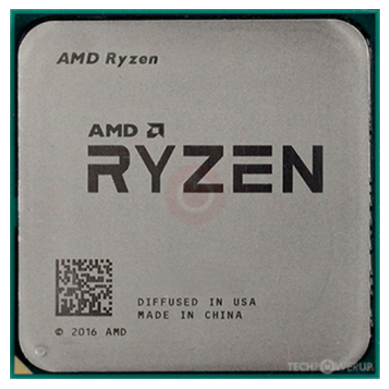

In [14]:
vector = df_vector["image"].iloc[9120]

# Convertir a array 3D
img_array = np.array(vector, dtype=np.uint8).reshape((530, 530, 3))

# Mostrar
plt.imshow(img_array)
plt.axis("off")
plt.show()